# Inpainting with homogeneous diffusion 
We will use the inpainting with Homogeneous diffusion to interpolate in a grid. The method is described in https://arxiv.org/pdf/1506.04566.pdf. We consider the following PDE with mixed boundary conditions
$$\begin{align}
\nabla u &= 0 \text{ on } \Omega \setminus \Omega_{K}\,, \\
u &= f  \text{ on } \Omega_K \,, \\
\partial_n u &= 0 \text{ on } \partial \Omega \setminus \partial \Omega_K\,.
\end{align}$$

Here $ \partial_n u $ denotes the outward normal.

We will now try to use Laplace interpolation on an 1D problem. We will use the following function:

                                                                        $f(x) = \exp{(2x -3)} + x\,,\quad x\in [-4, 4]\, $.

In [2]:
using Laplacians, LinearAlgebra, SparseArrays
using TestImages, Colors, Plots, FileIO, JLD

In [3]:
x_array = -4:0.08:4;
x_array = collect(x_array);
N = length(x_array);
f_array = exp.(2*x_array .- 3) + x_array;
discard = rand(2:100, 30);
discard = unique(discard);
all = collect(1:length(x_array));
keep = setdiff(all, discard);
length(keep);

In [4]:
#Constructing the Laplace matrix
h = 0.08;
ev = 1/h^2*ones(N-1,1);
dv = -ones(N,1)*2/h^2
A = Tridiagonal([fill(1.0/h^2, N-2); 0.0], [1.0; fill(-2.0/h^2, N-2); 1.0], [0.0; fill(1.0/h^2, N-2);]);

In [5]:
#Constructing C
diag_c = ones(N);
diag_c[discard] .= 0;
C = diagm(diag_c);
Id = Matrix(1.0I, N,N);

In [14]:
u = (C-(Id -C)*A)\(C*f_array);
pa = plot(x_array, f_array, label="Truth", lw=3, legendfont=font(18), xtickfont=font(18), 
    ytickfont=font(18))
plot!(pa, x_array, u, label = "Reconstruction", lw = 3, legendfont=font(18), xtickfont=font(18), 
    ytickfont=font(18))
savefig("Example_1D.png")

In [16]:
#Verifying if the second derivative at the discarded points is 0
norm((A*u)[discard])

5.092787486850253e-13

# 2D Example
We will use the Mandrill image to test the approach.


In [17]:
img = testimage("mandrill");
imgg = Gray.(img);
mat = convert(Array{Float64}, imgg)[1:256,1:512];
# This image is square
#plot(imgg)

In [18]:
rows = size(mat,1);
columns = size(mat,2);
BoundaryNodes1 = collect(1:rows);
BoundaryNodes2 = collect(rows+1:rows:rows*columns-rows+1);
BoundaryNodes3 = collect(rows*columns-rows+2:rows*columns);
BoundaryNodes4 = collect(2*rows:rows:(columns-1)*rows);
BoundaryNodes= union(BoundaryNodes1, BoundaryNodes2, BoundaryNodes3, BoundaryNodes4);
AllNodes = collect(1:rows*columns)
NonBoundaryNodes = setdiff(AllNodes, BoundaryNodes);
size(NonBoundaryNodes);

In [19]:
#Now we discard about 50% of the non boundary nodes
No_of_nodes_discarded = 60000
discard = rand(1:length(NonBoundaryNodes), No_of_nodes_discarded);
discard = unique(discard);
discard = NonBoundaryNodes[discard];

In [20]:
#Constructing the 2D Laplace matrix
function spdiagm_nonsquare(m, n, args...)
    I, J, V = SparseArrays.spdiagm_internal(args...)
    return sparse(I, J, V, m, n)
end

# returns -∇² (discrete Laplacian, real-symmetric positive-definite) on n₁×n₂ grid
function ∇²(n₁,n₂)
    o₁ = ones(n₁)
    ∂₁ = spdiagm_nonsquare(n₁+1,n₁,-1=>-o₁,0=>o₁)
    o₂ = ones(n₂)
    ∂₂ = spdiagm_nonsquare(n₂+1,n₂,-1=>-o₂,0=>o₂)
    return kron(sparse(I,n₂,n₂), ∂₁'*∂₁) + kron(∂₂'*∂₂, sparse(I,n₁,n₁))
end

∇² (generic function with 1 method)

In [24]:
A = ∇²(rows,columns);

In [45]:
#Enforcing Dirichlet Boundary conditions
A[BoundaryNodes,:] .= 0
A[:,BoundaryNodes] .= 0
A[BoundaryNodes, BoundaryNodes] = sparse(I, length(BoundaryNodes), length(BoundaryNodes));
A;
holeyimage1 = mat;
holeyimage1[discard].=1
plot(Gray.(holeyimage1), title="Image with Missing data")
savefig("Mandrill_missing.png")
mat = convert(Array{Float64}, imgg)[1:256,1:512];

In [46]:
#Constructing C
C = sparse(I, rows*columns, rows*columns)
C[discard,discard] .= 0
Id = sparse(I, rows*columns,rows*columns);
f = mat[:];
u =((C-(Id -C)*A)) \ (C*f);
restored_img = reshape(u, size(mat,1), size(mat,2));
plot(Gray.(restored_img), title="Inpainting_Homogeneous_Diffusion")
savefig("Mandrill_Reconstructed.png")

In [47]:
plot(imgg[1:size(mat,1),1:size(mat,2)], title="Original")
savefig("Mandrill_Truth.png")
A_new  = ∇²(rows,columns);
maximum((A_new*u)[discard] .< 1e-6) == length(discard);

In [48]:
maximum((A_new*u)[discard])

7.771561172376096e-16

# Adding holes to the Mandrill Image

In [49]:
cent = [(100, 200), (200, 100), (400, 200)]
c = cent[1]
rad = 20

L = 1:size(mat,1)
K = 1:size(mat,2)

mask = ones(size(mat))
mask = broadcast(+, (L .- c[1]).^2, (K .- c[2])'.^2) .> rad^2

keep = collect(1:prod(size(mat)))

fun(c, k) = filter(x -> (floor(x/size(mat,1)) .- c[1]).^2 + (x%size(mat,1) .- c[2])'.^2 > rad^2, k)

keep = fun(cent[1], keep)
keep = fun(cent[2], keep)
keep = fun(cent[3], keep)

prod(size(mask)) - sum(mask[keep]), 2*20^2*pi;

In [50]:
S = [i*size(mat,2)+j for i in 0:(size(mat,1)-1) for j in 1:size(mat,2)]
vals = mat[:]
holeyimage = ones(size(mat,1),size(mat,2))
holeyimage[S[keep]] = vals[keep]
plot(Gray.(holeyimage))
savefig("MandrilWithHoles.png")

In [51]:
discard = setdiff(AllNodes, keep);

In [52]:
C = sparse(I, rows*columns, rows*columns)
C[discard,discard] .= 0
Id = sparse(I, rows*columns,rows*columns);
f = mat[:];
@time u =((C-(Id -C)*A)) \ (C*f);
restored_img = reshape(u, size(mat,1), size(mat,2));
plot(Gray.(restored_img), title="Inpainting_Homogeneous_Diffusion")
savefig("MandrilWithHolesRestored.png")

  0.082095 seconds (101 allocations: 84.275 MiB, 18.78% gc time)


In [26]:
save("Mandrill_Holes_Restored_Global.jld", "Mandrill_Holes_Restored_Global", u)
sum((A_new*u)[discard] .< 1e-6) == length(discard)

true

In [53]:
#Constructing the 3D Laplace matrix
function spdiagm_nonsquare(m, n, args...)
    I, J, V = SparseArrays.spdiagm_internal(args...)
    return sparse(I, J, V, m, n)
end

# returns -∇² (discrete Laplacian, real-symmetric positive-definite) on n₁×n₂ grid
function ∇²3d(n₁,n₂,n3)
    o₁ = ones(n₁)
    ∂₁ = spdiagm_nonsquare(n₁+1,n₁,-1=>-o₁,0=>o₁)
    o₂ = ones(n₂)
    ∂₂ = spdiagm_nonsquare(n₂+1,n₂,-1=>-o₂,0=>o₂)
    O3 = ones(n3)
    del3 = spdiagm_nonsquare(n3+1,n3,-1=>-O3,0=>O3)
    return kron(sparse(I,n3,n3),sparse(I,n₂,n₂), ∂₁'*∂₁) + kron(sparse(I,n3,n3), ∂₂'*∂₂, sparse(I,n₁,n₁)) + kron(del3'*del3, sparse(I,n₂,n₂), sparse(I,n₁,n₁))
end

∇²3d (generic function with 1 method)

We will now solve a simple Poisson problem $-\Delta u =  f $ with homogeneous Dirichlet boundary conditions to verify the correctness of our Laplace operator. We will use the method of manufactured solutions with $u = \sin(2 \pi x) \sin(2\pi y) \sin(2\pi z)$.

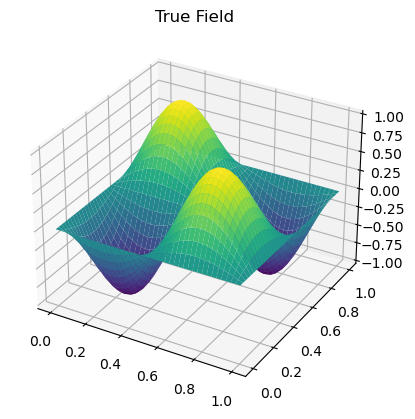

PyObject Text(0.5, 1.0, 'True Field')

In [75]:
using VectorizedRoutines, PyPlot
h = 0.025
x_dir = collect(0:h:1);
y_dir = collect(0:h:1);
z_dir = collect(0:h:1);
xmesh, ymesh, zmesh = Matlab.meshgrid(x_dir, y_dir, z_dir);
u_true = sin.(2*pi*xmesh).*sin.(2*pi*ymesh).*sin.(2*pi*zmesh);
surf(xmesh[:,:,1], ymesh[:,:,1], u_true[:,:,31], cmap=ColorMap("viridis"));
title("True Field")

In [72]:
ngrid = convert(Int64, 1/h+1);
rhs_f = -12*pi^2*sin.(2*pi*xmesh).*sin.(2*pi*ymesh).*sin.(2*pi*zmesh);
rhs_f = rhs_f[:];
A3D = -∇²3d(ngrid, ngrid, ngrid)/h^2;

In [78]:
function return_boundary_nodes(xpoints, ypoints, zpoints)
    BoundaryNodes3D =[];
    counter = 0;
    for k = 1:zpoints
        for j = 1:ypoints
            for i = 1:xpoints
                counter=counter+1;
                if(k == 1 || k == zpoints || j == 1|| j == ypoints || i == 1 || i == xpoints)
                    BoundaryNodes3D = push!(BoundaryNodes3D, counter)
                end
            end
        end
    end
    return BoundaryNodes3D
end
bnodes = return_boundary_nodes(ngrid,ngrid,ngrid);


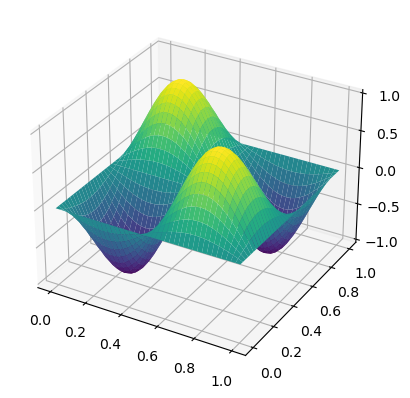

In [79]:
#Enforcing Dirichlet Boundary Conditions:
#Enforcing Dirichlet Boundary conditions
A3D[bnodes,:] .= 0
A3D[:,bnodes] .= 0
A3D[bnodes, bnodes] = sparse(I, length(bnodes), length(bnodes));
u_approx_vector = A3D\rhs_f;
u_approx = reshape(u_approx_vector, ngrid, ngrid, ngrid);
surf(xmesh[:,:,1], ymesh[:,:,1], u_approx[:,:,31], cmap=ColorMap("viridis"));

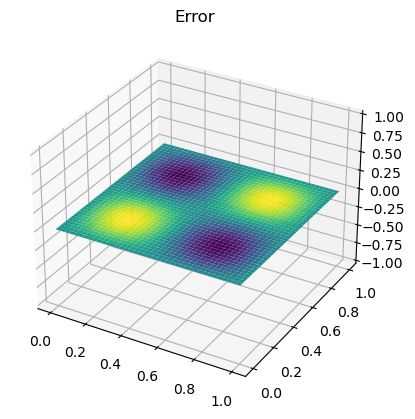

PyObject Text(0.5, 1.0, 'Error')

In [81]:
norm(u_approx[:] - u_true[:])
error = reshape(u_true[:] -u_approx[:], ngrid,ngrid,ngrid);
surf(xmesh[:,:,1], ymesh[:,:,1], error[:,:,31], cmap=ColorMap("viridis"));
zlim([-1,1])
title("Error")

In [87]:
AllNodes3D = collect(1:ngrid*ngrid*ngrid)
NonBoundaryNodes3D = setdiff(AllNodes3D, bnodes);

In [88]:
#Now we discard about 50% of the non boundary nodes
No_of_nodes_discarded = 30000
discard = rand(1:length(NonBoundaryNodes3D), No_of_nodes_discarded);
discard = unique(discard);
discard = NonBoundaryNodes3D[discard];

In [89]:
#Constructing C
C = sparse(I, ngrid*ngrid*ngrid, ngrid*ngrid*ngrid)
C[discard,discard] .= 0
Id = sparse(I, ngrid^3,ngrid^3);
f = u_true[:];
u =((C-(Id -C)*A3D)) \ (C*f);
restored_img = reshape(u, ngrid, ngrid, ngrid);

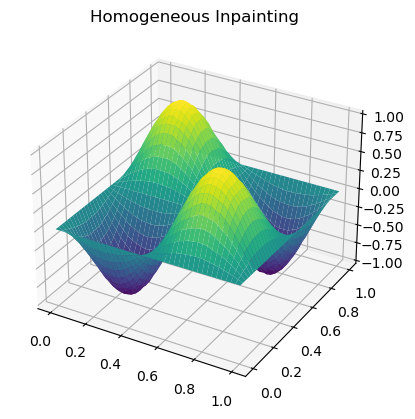

PyObject Text(0.5, 1.0, 'Homogeneous Inpainting')

In [90]:
restored_img = reshape(u, ngrid, ngrid, ngrid);
surf(xmesh[:,:,1], ymesh[:,:,1], restored_img[:,:,31], cmap=ColorMap("viridis"));
zlim([-1,1])
title("Homogeneous Inpainting")

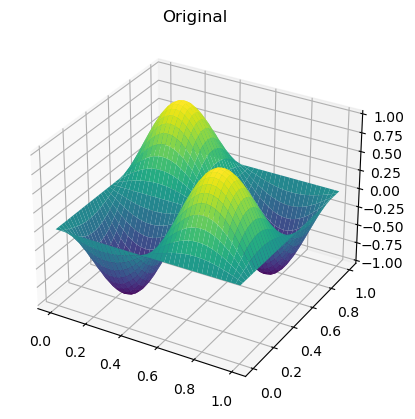

PyObject Text(0.5, 1.0, 'Original')

In [41]:
surf(xmesh[:,:,1], ymesh[:,:,1], u_true[:,:,31], cmap=ColorMap("viridis"))
title("Original")

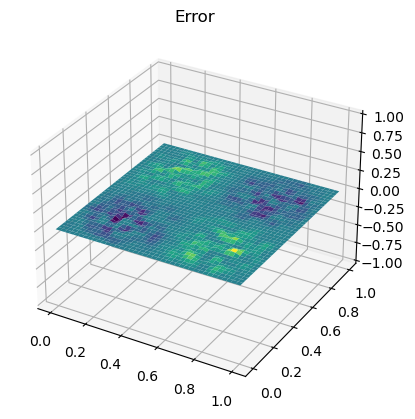

PyObject Text(0.5, 1.0, 'Error')

In [93]:
surf(xmesh[:,:,1], ymesh[:,:,1], (u_true - restored_img)[:,:,31], cmap=ColorMap("viridis"))
zlim([-1,1])
title("Error")

In [43]:
maximum((A3D*u)[discard])

2.2737367544323206e-12

# 3D Giphy Example

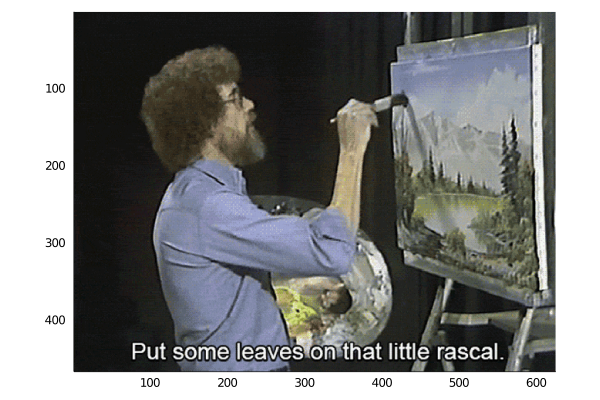

In [44]:
obj = load("/Users/vishwasrao/Research/BES_Project/2020_06_Jun/06112020_Meeting/giphy.gif")

# 14 frames, here is the first one
plot(obj[:,:,1])

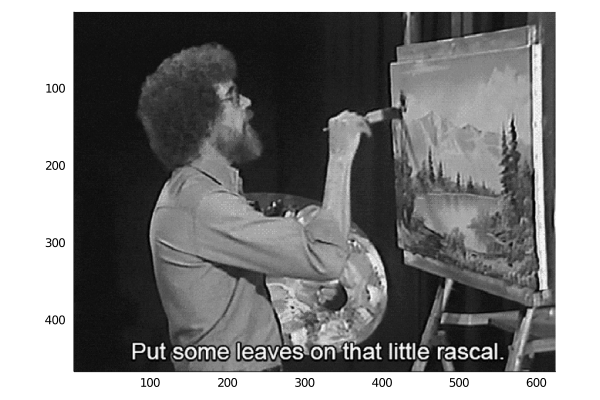

(467, 625, 14)

In [45]:
using GR
GR.inline()
nsteps = 14
imgg = Gray.(obj)
for n = 1:nsteps
    IJulia.clear_output(true)
    plot(imgg[:,:,n])  |> display
end
size(imgg)

In [46]:
AllNodesGiphy = 1:prod(size(imgg));

In [47]:
xpoints = size(imgg, 1);
ypoints = size(imgg, 2);
zpoints = size(imgg, 3);
BoundaryNodesGiphy = return_boundary_nodes(xpoints,ypoints,zpoints);

In [48]:
NonBoundaryNodesGiphy = setdiff(AllNodesGiphy, BoundaryNodesGiphy);
size(NonBoundaryNodesGiphy)

(3476340,)

In [49]:
No_of_nodes_discarded = 3000000;
discard = rand(1:length(NonBoundaryNodesGiphy), No_of_nodes_discarded);
discard = unique(discard);
discard = NonBoundaryNodesGiphy[discard];

In [ ]:
A3DGiphy = -∇²3d(xpoints, ypoints, zpoints);
A3DGiphy[BoundaryNodesGiphy, BoundaryNodesGiphy] = sparse(I, length(BoundaryNodesGiphy), length(BoundaryNodesGiphy));

In [46]:
totalsize = prod(size(imgg));
C = sparse(I, totalsize, totalsize)
C[discard,discard] .= 0
Id = sparse(I, totalsize, totalsize);
f = imgg[:];
u =((C-(Id -C)*A3DGiphy)) \ (C*f);
restored_img = reshape(u, xpoints, ypoints, zpoints);

LoadError: MethodError: no method matching ldiv!(::SuiteSparse.UMFPACK.UmfpackLU{Float64,Int64}, ::Array{Gray{Float64},1})
Closest candidates are:
  ldiv!(!Matched::Number, ::AbstractArray) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/generic.jl:251
  ldiv!(!Matched::Transpose{var"#s828",var"#s827"} where var"#s827"<:(LU{var"#s826",var"#s825"} where var"#s825"<:(StridedArray{T, 2} where T) where var"#s826") where var"#s828", ::StridedVecOrMat{T} where T) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/lu.jl:402
  ldiv!(!Matched::Adjoint{var"#s828",var"#s827"} where var"#s827"<:(LU{var"#s826",var"#s825"} where var"#s825"<:(StridedArray{T, 2} where T) where var"#s826") where var"#s828", ::StridedVecOrMat{T} where T) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/lu.jl:413
  ...